## Brief description of the problem and data
Create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans using Deep Learning.

### Git Repo
Link: https://github.com/Lenni-A/Deep_Learning/tree/main/week3

### Data
Source data: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

The dataset provides a large number of small pathology images (96px x 96px) to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. Algorithm should predict the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
path_train = './data/train/'
path_test = './data/test/'
print("Train image count: ", len(os.listdir(path_train)))
df_full_train = pd.read_csv('./data/train_labels.csv')
df_full_train.info()
print("\nTest image count: ", len(os.listdir(path_test)))
df_test = pd.DataFrame()
df_test['id']=os.listdir(path_test)
df_test.info()

Train image count:  220025
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB

Test image count:  57458
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
dtypes: object(1)
memory usage: 449.0+ KB


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
Show a few visualizations like histograms. Describe any data cleaning procedures.


Label data summary (0=Neg / 1=Pos): 0    130908
1     89117
Name: label, dtype: int64


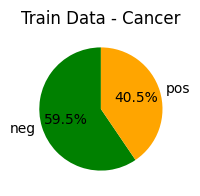

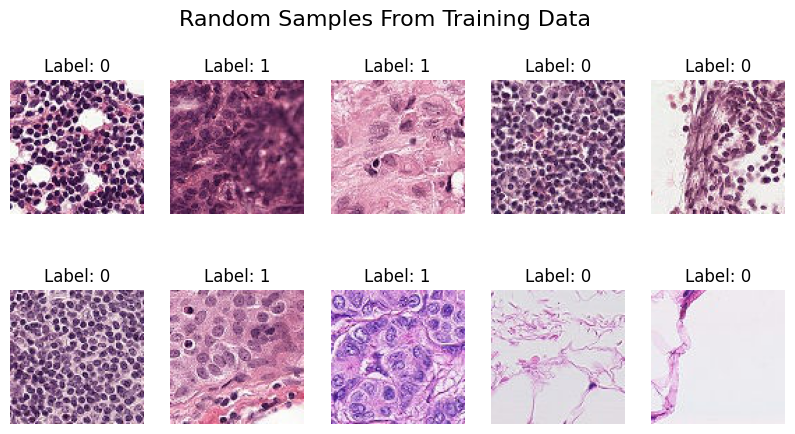

In [3]:
labels = df_full_train['label'].value_counts()
print("\nLabel data summary (0=Neg / 1=Pos):", labels)

# Plot as pie chart
plt.figure(figsize=(2, 2))
plt.pie(labels, labels=['neg', 'pos'], autopct='%1.1f%%', startangle=90, colors=['green', 'orange'])
plt.title('Train Data - Cancer')
plt.show()

# Show random samples from training data.
img_cnt = 10
fig, axs = plt.subplots(2, img_cnt // 2, figsize=(10, 5))
train_imgs = os.listdir(path_train)
for ax in axs.ravel():
    file_img = np.random.choice(train_imgs)
    img = image.imread(os.path.join(path_train, file_img))
    lab = df_full_train.loc[df_full_train['id'] == file_img.split('.')[0], 'label'].values[0]
    ax.imshow(img)
    ax.set_title(f'Label: {lab}')
    ax.axis('off')
plt.suptitle('Random Samples From Training Data', fontsize=16)
plt.show()

# Data is clean, no duplicates.

## DModel Architecture
Describe model architecture and reasoning for why that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.

### Image generators
Use Keras ImageDataGenerator which provides real-time data transformation and augmentation of the original image, creating new sets of images useful in training models.

In [4]:
df_train, df_valid = train_test_split(df_full_train, test_size=0.2, random_state=39, stratify=df_full_train.label)

def create_data_gen(path_data, df_data, y_col_name:str = None, batch_size:int = 2, class_mode:str = 'categorical'):
    data_gen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    target_size = (96, 96)
    if y_col_name is not None:
        df_data[y_col_name] = df_data[y_col_name].astype(str)
        df_data['id'] = df_data['id'] + '.tif'

    gen = data_gen.flow_from_dataframe(
        dataframe=df_data,
        directory=path_data,
        x_col='id',
        y_col=y_col_name,
        target_size=target_size,
        batch_size=batch_size,
        seed=42,
        shuffle=False,
        has_ext=True,
        class_mode=class_mode
        )
    return gen

train_gen = create_data_gen(path_train, df_train, 'label')
valid_gen = create_data_gen(path_train, df_valid, 'label')
test_gen = create_data_gen(path_test, df_test, None, 1, None)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


### Create Model
Use CNN which is very suitable for image recognition. Create 3 CNN models with starting setup of 1 set of conv layer (3 per set) with 16 filters, MaxPool and Dropout. The conv layer is increased by one and the filters doubled for each iteration. For execution use low epoch of 5 with epoch steps of 10 and validation steps of 2. 

In [33]:
def create_model(conv_layers:int, filter_count:int = 32):
    activation_relu = 'relu'
    activation_softmax = 'softmax'
    kernel_size = (3,3)
    pool_size= (2,2)
    output_filter_count = 2
    dropout_conv = 0.3
    dropout_dense = 0.2

    model = Sequential()
    filter_count = filter_count
    for i in range(conv_layers):
        if i==0:
            model.add(Conv2D(filter_count, kernel_size, activation = activation_relu, input_shape = (96, 96, 3)))
        else:
            model.add(Conv2D(filter_count, kernel_size, activation = activation_relu))
        model.add(Conv2D(filter_count, kernel_size, activation = activation_relu))
        model.add(Conv2D(filter_count, kernel_size, activation = activation_relu))
        model.add(MaxPooling2D(pool_size = pool_size)) 
        model.add(Dropout(dropout_conv))
        filter_count = filter_count * 2

    model.add(Flatten())
    model.add(Dense(filter_count, activation = activation_relu))
    model.add(Dropout(dropout_dense))
    model.add(Dense(output_filter_count, activation = activation_softmax))
    model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Create different models with different layers and filters.
model_trained = None
model_count = 3
layer_count = 1
filter_count = 16
best_acc = 0
for x in range(model_count):
    print(f'\n----- CREATING MODEL {x} (Layers: {layer_count} / Filters: {filter_count})-----')
    model = create_model(layer_count, filter_count)
    model.summary()
    epoch = 5
    epoch_steps = 10
    val_steps = 2
    print('----- TRAINING MODEL -----')
    mt = model.fit(
        train_gen,
        steps_per_epoch=epoch_steps,
        epochs=epoch,
        validation_data=valid_gen,
        validation_steps=val_steps,
        verbose=1
    )
    acc = np.mean(mt.history['accuracy'])
    print(f'MEAN ACCURACY: {acc}')
    if acc > best_acc:
        best_acc = acc
        model_trained = mt
    layer_count += 1
    filter_count *= 2


----- CREATING MODEL 0 (Layers: 1 / Filters: 16)-----
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_312 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 conv2d_313 (Conv2D)         (None, 92, 92, 16)        2320      
                                                                 
 conv2d_314 (Conv2D)         (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 45, 45, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_147 (Dropout)       (None, 45, 45, 16)        0         
                                                                 
 flatten_46 (Flatten)        (None, 32400)             0        

## Results and Analysis
Based on the training output the CNN model with 3 convolutional layers using 64 filters has the best mean accuracy, suggesting that the model has learned to recognize patterns and features in the images, leading to better predictions. Fine tune this model with different hyperparameters to achieve a higher accuracy.  

In [36]:
layer_count = 3
filter_count = 64
model = create_model(layer_count, filter_count)
model.summary()
best_acc = 0
model_trained = None
df = pd.DataFrame(columns=['Epoch', 'Epoch_Steps', 'Val_Steps', 'Loss', 'Acc'])

epochs = [10, 20, 50, 100]
epoch_steps = [10, 20, 30, 50]
val_steps = [2, 3, 4, 5]
for i, epoch in enumerate(epochs):
    print(epoch, epoch_steps[i])
    print('----- TRAINING MODEL -----')
    mt = model.fit(
        train_gen,
        steps_per_epoch=epoch_steps[i],
        epochs=epoch,
        validation_data=valid_gen,
        validation_steps=val_steps[i],
        verbose=1
    )
    acc = np.mean(mt.history['accuracy'])
    loss = np.mean(mt.history['loss'])
    print(f'MEAN ACCURACY: {acc}')
    if acc > best_acc:
        best_acc = acc
        model_trained = mt
    df.loc[len(df)] = [epoch, epoch_steps[i], val_steps[i], loss, acc]
print(df)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_330 (Conv2D)         (None, 94, 94, 64)        1792      
                                                                 
 conv2d_331 (Conv2D)         (None, 92, 92, 64)        36928     
                                                                 
 conv2d_332 (Conv2D)         (None, 90, 90, 64)        36928     
                                                                 
 max_pooling2d_108 (MaxPooli  (None, 45, 45, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_156 (Dropout)       (None, 45, 45, 64)        0         
                                                                 
 conv2d_333 (Conv2D)         (None, 43, 43, 128)       73856     
                                                     

#### Measurement
Plot the training result of the best model which has the lowest epoch for Loss and Accuracy.

Looking at the calculation logs and the stats, the low epoch count might not allow the model to fully converge and capture the underlying patterns of the images data. The initial training loss is extremely high (3041.38147) in the first epoch which could indicate a potential problem with the model's convergence. Additionally the imbalanced values in the Loss and Acc columns across different epochs and val steps config suggest that the models may not have been trained for a sufficient duration or with appropriate steps, potentially leading to biased results.

In [43]:
# Add the stats manually (to avoid re-running calculation).
df = pd.DataFrame(columns=['Epoch', 'Epoch_Steps', 'Val_Steps', 'Loss', 'Acc'])
df.loc[len(df)] = [10, 10, 2, 3041.38147, 0.6050]
df.loc[len(df)] = [20, 20, 3, 0.0342, 0.5813]
df.loc[len(df)] = [50, 30, 4, 0.6780, 0.5943]
df.loc[len(df)] = [100, 50, 5, 0.6765, 0.6006]
df.head()

,Epoch,Epoch_Steps,Val_Steps,Loss,Acc
0,10.0,10.0,2.0,3041.38147,0.6050
1,20.0,20.0,3.0,0.03420,0.5813
2,50.0,30.0,4.0,0.67800,0.5943
3,100.0,50.0,5.0,0.67650,0.6006


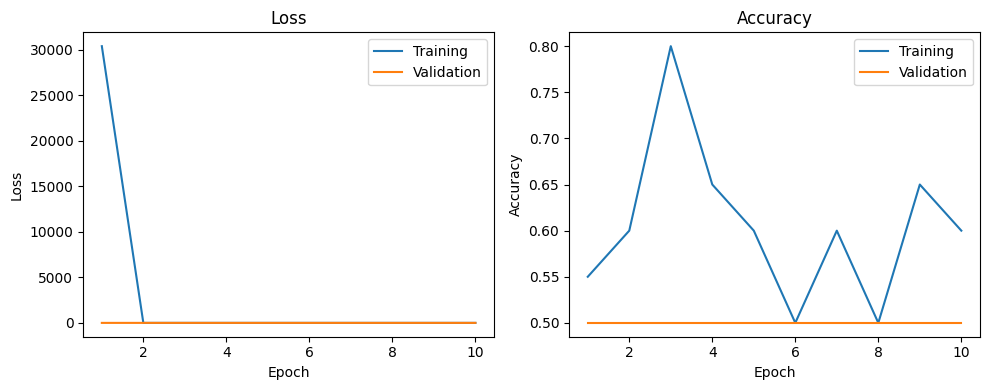

In [44]:
def plot_metrics(history, metrics):
    epoch_cnt = range(1, len(history[metrics[0]]) + 1)
    metrics_cnt = len(metrics)
    plt.figure(figsize=(10, 4))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, metrics_cnt, i)
        plt.plot(epoch_cnt, history[metric], label='Training')
        plt.plot(epoch_cnt, history[f'val_{metric}'], label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.title(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(model_trained.history, ['loss', 'accuracy'])

#### Trained model with test data
Use the trained model with test data. Save result for Kaggle submission.

In [45]:
pred_values = model.predict_generator(test_gen, verbose=1)
df_submission = pd.DataFrame({'id': test_gen.filenames, 'label': np.argmax(pred_values, axis=1) })
df_submission['id'] = df_submission['id'].apply(lambda x: x.split('.')[0])
df_submission.to_csv('cancer_detection_submission.csv', index=False)


    1/57458 [..............................] - ETA: 32:33

e:\Learn\_Code_\3_Introduction to Deep Learning\.venv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


57458/57458 [==============================] - 129s 2ms/step


## Conclusion
The created CNN model with a total of 6,640,130 parameters is trained on a dataset of 176,020 images using the Adam optimizer and binary cross-entropy loss function. It's architecture includes multiple convolutional and pooling layers, followed by dense layers which should provide the approriate setup to identify a high amount of the images correctly. However the training results indicate that the model struggles to learn, despite a decrease in loss in subsequent epochs, the accuracy does not show substantial improvement, reaching a mean accuracy of 60.5%.

To enhance the model several improvements could be explored such as hyperparameter tuning, trying different architectures and consideration of other regularization techniques. Additionally, experimenting with different optimizers or learning rate schedules may achieve better stability and convergence during training. 